Epoch 1/20 | Train Loss: 4.9547 | Train Acc: 16.22% | Val Loss: 2.2093 | Val Acc: 33.73%
Epoch 2/20 | Train Loss: 1.2655 | Train Acc: 62.66% | Val Loss: 1.1745 | Val Acc: 65.87%
Epoch 3/20 | Train Loss: 0.4814 | Train Acc: 85.20% | Val Loss: 0.8156 | Val Acc: 75.00%
Epoch 4/20 | Train Loss: 0.2931 | Train Acc: 91.29% | Val Loss: 0.6670 | Val Acc: 80.16%
Epoch 5/20 | Train Loss: 0.1945 | Train Acc: 94.88% | Val Loss: 1.0588 | Val Acc: 69.44%
Epoch 6/20 | Train Loss: 0.1433 | Train Acc: 96.02% | Val Loss: 0.6167 | Val Acc: 81.35%
Epoch 7/20 | Train Loss: 0.1767 | Train Acc: 95.22% | Val Loss: 0.8434 | Val Acc: 74.21%
Epoch 8/20 | Train Loss: 0.1356 | Train Acc: 96.70% | Val Loss: 0.9128 | Val Acc: 76.98%
Epoch 9/20 | Train Loss: 0.1095 | Train Acc: 97.21% | Val Loss: 0.8607 | Val Acc: 76.59%
Epoch 10/20 | Train Loss: 0.0674 | Train Acc: 98.80% | Val Loss: 0.7721 | Val Acc: 78.57%
Epoch 11/20 | Train Loss: 0.0748 | Train Acc: 98.18% | Val Loss: 0.8607 | Val Acc: 79.76%
Epoch 12/20 | Train

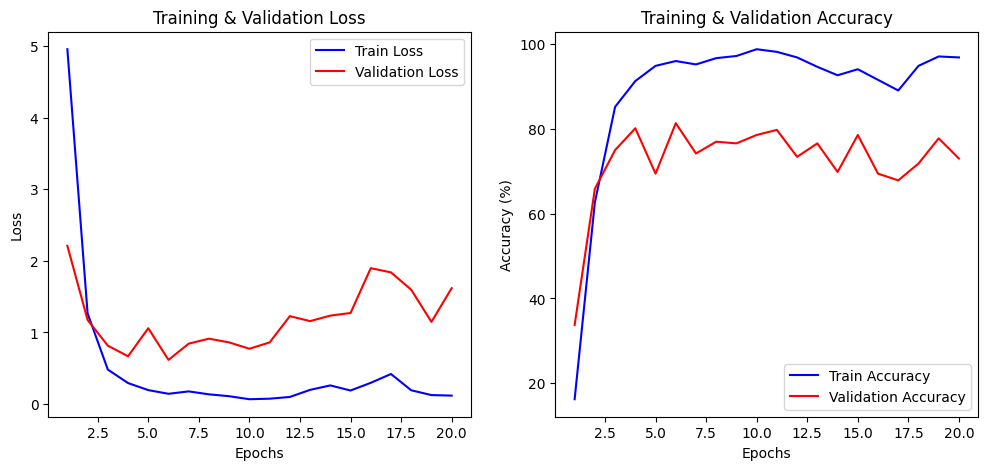

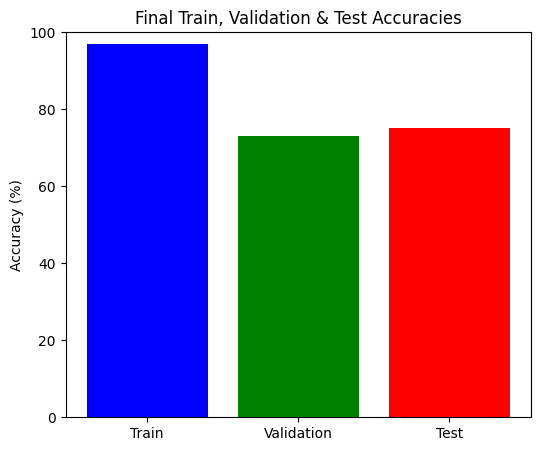

Train Accuracy: 96.87%
Test Accuracy: 75.10%
Validation Accuracy: 73.02%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Load dataset
X = np.load("X_features.npy")
y = np.load("y_labels.npy")

# Split data: Train (70%), Test (20%), Validation (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42)

# Conversion to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Definition of the MLP model (ReLU is used as Activation function)
class MLP(nn.Module):
    def __init__(self, input_size=4000, hidden_size=128, output_size=50):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Setup device, model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20


train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training and Validation
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct * 100 / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            val_correct += (predicted == batch_y).sum().item()
            val_total += batch_y.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct * 100 / val_total)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.2f}% | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]:.2f}%")

print("Training Done")

# Evaluate on the test set
model.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        predicted = torch.argmax(outputs, dim=1)
        test_correct += (predicted == batch_y).sum().item()
        test_total += batch_y.size(0)

test_accuracy = test_correct * 100 / test_total

print(f"Final Test Accuracy: {test_accuracy:.2f}%")

# Plotting of Loss and Accuracy Curves
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", color="blue")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy", color="blue")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()

# Bar Chart for Final Accuracies
labels = ["Train", "Validation", "Test"]
accuracies = [train_accuracies[-1], val_accuracies[-1], test_accuracy]
colors = ["blue", "green", "red"]

plt.figure(figsize=(6, 5))
plt.bar(labels, accuracies, color=colors)
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("Final Train, Validation & Test Accuracies")
plt.show()

# Print Final Accuracies
print(f"Train Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Validation Accuracy: {val_accuracies[-1]:.2f}%")

Top_n = 20: Final Train Acc = 99.20%, Val Acc = 84.52%, Test Acc = 88.25%
Top_n = 22: Final Train Acc = 98.98%, Val Acc = 83.73%, Test Acc = 88.45%
Top_n = 24: Final Train Acc = 99.32%, Val Acc = 84.52%, Test Acc = 87.05%
Top_n = 26: Final Train Acc = 99.15%, Val Acc = 85.71%, Test Acc = 87.45%
Top_n = 28: Final Train Acc = 99.32%, Val Acc = 86.11%, Test Acc = 87.05%
Top_n = 30: Final Train Acc = 99.26%, Val Acc = 87.70%, Test Acc = 89.64%
Top_n = 32: Final Train Acc = 99.37%, Val Acc = 84.52%, Test Acc = 87.25%
Top_n = 34: Final Train Acc = 99.54%, Val Acc = 87.70%, Test Acc = 88.05%
Top_n = 36: Final Train Acc = 99.60%, Val Acc = 85.71%, Test Acc = 89.44%
Top_n = 38: Final Train Acc = 99.54%, Val Acc = 86.11%, Test Acc = 90.24%
Top_n = 40: Final Train Acc = 99.66%, Val Acc = 83.73%, Test Acc = 88.45%


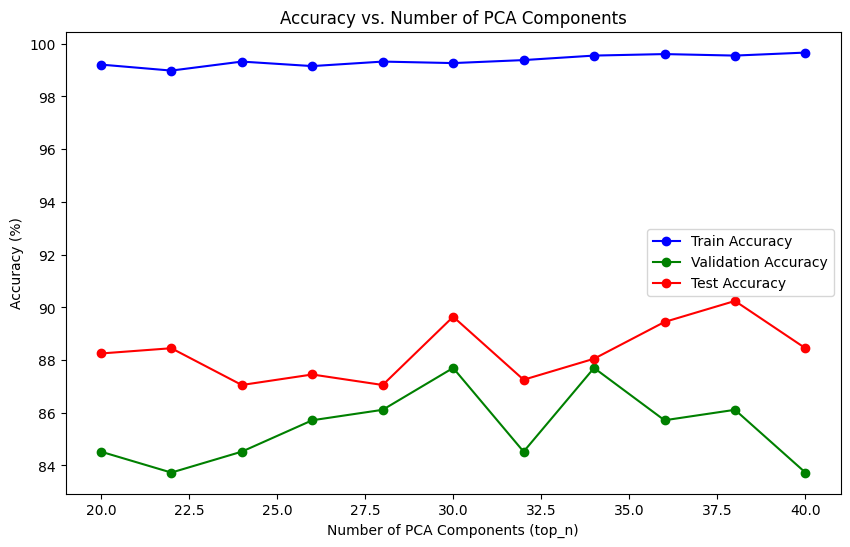

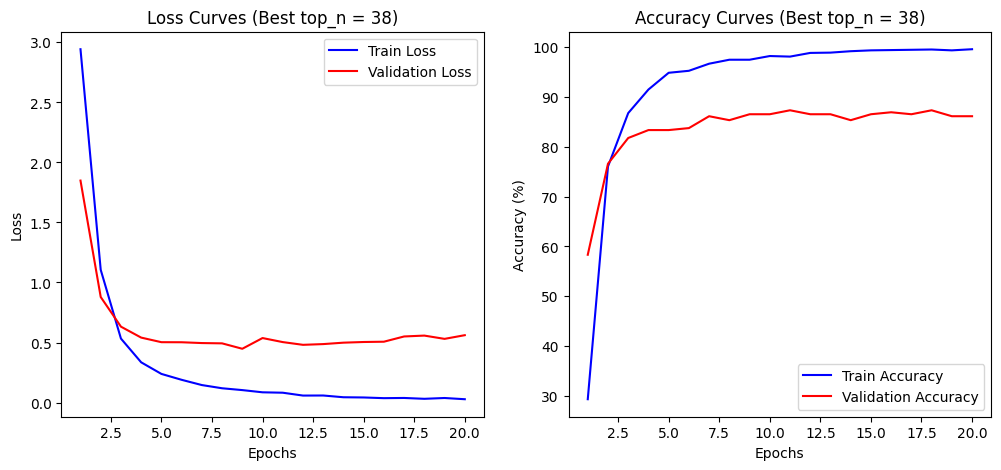

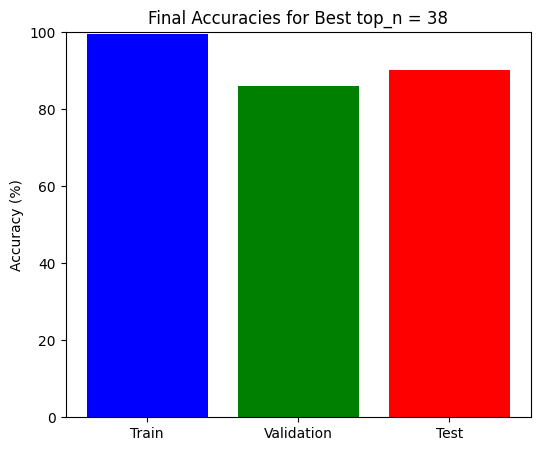

Best Accuracies at top_n = 38
Train Accuracy: 99.54%
Validation Accuracy: 86.11%
Test Accuracy: 90.24%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


# PCA Implementation


def standardise_data(dataset, mean=None, std_dev=None):
    if mean is None or std_dev is None:
        mean = np.mean(dataset, axis=0)
        std_dev = np.std(dataset, axis=0)
    std_data = (dataset - mean) / std_dev
    return std_data, mean, std_dev

def covariance_matrix(dataset):
    m = dataset.shape[0]  # number of samples
    cov_matrix = np.dot(dataset.T, dataset) / (m - 1)
    return cov_matrix

def eigenvalues_eigenvectors(cov_matrix):
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    return eigenvalues, eigenvectors

def sort_eigenpairs(eigenvalues, eigenvectors):
    sorted_indices = np.argsort(eigenvalues)[::-1]  # descending order
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvalues, sorted_eigenvectors

def project_dataset_to_new_plane(X, eigenvectors, top_n=1):
    W = eigenvectors[:, :top_n]
    projected_data = np.dot(X, W)
    return projected_data

# Definition of the MLP model (ReLU is used as Activation function)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=50):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


X = np.load("X_features.npy")
y = np.load("y_labels.npy")

# Split: 70% Train, 30% Temp, then split Temp into Test (20%) and Validation (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42)


X_train_std, train_mean, train_std = standardise_data(X_train)
X_val_std, _, _ = standardise_data(X_val, train_mean, train_std)
X_test_std, _, _ = standardise_data(X_test, train_mean, train_std)


# Loop over different top_n values for PCA

top_n_values = list(range(20, 41, 2))
final_train_accs = []
final_val_accs = []
final_test_accs = []


best_test_acc = -1
best_top_n = None
best_epoch_train_losses = None
best_epoch_val_losses = None
best_epoch_train_accs = None
best_epoch_val_accs = None


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 20
batch_size = 32

for top_n in top_n_values:
    # Compute PCA on training data
    cov_mat = covariance_matrix(X_train_std)
    eigvals, eigvecs = eigenvalues_eigenvectors(cov_mat)
    sorted_eigvals, sorted_eigvecs = sort_eigenpairs(eigvals, eigvecs)

    # Project datasets to new space with top_n components
    X_train_proj = project_dataset_to_new_plane(X_train_std, sorted_eigvecs, top_n=top_n)
    X_val_proj   = project_dataset_to_new_plane(X_val_std, sorted_eigvecs, top_n=top_n)
    X_test_proj  = project_dataset_to_new_plane(X_test_std, sorted_eigvecs, top_n=top_n)

    # Create PyTorch tensors and datasets
    X_train_tensor = torch.tensor(X_train_proj, dtype=torch.float32)
    X_val_tensor   = torch.tensor(X_val_proj, dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test_proj, dtype=torch.float32)

    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_val_tensor   = torch.tensor(y_val, dtype=torch.long)
    y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    
    model = MLP(input_size=top_n).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Store epoch-wise loss and accuracy curves for this top_n
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accs = []
    epoch_val_accs = []

    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
        train_loss = total_loss / len(train_loader)
        train_acc = correct * 100 / total

        epoch_train_losses.append(train_loss)
        epoch_train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)
                val_correct += (predicted == batch_y).sum().item()
                val_total += batch_y.size(0)
        val_loss_avg = val_loss / len(val_loader)
        val_acc = val_correct * 100 / val_total

        epoch_val_losses.append(val_loss_avg)
        epoch_val_accs.append(val_acc)

    # Evaluate on test set after training
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            predicted = torch.argmax(outputs, dim=1)
            test_correct += (predicted == batch_y).sum().item()
            test_total += batch_y.size(0)
    test_acc = test_correct * 100 / test_total

    final_train_accs.append(epoch_train_accs[-1])
    final_val_accs.append(epoch_val_accs[-1])
    final_test_accs.append(test_acc)

    print(f"Top_n = {top_n}: Final Train Acc = {epoch_train_accs[-1]:.2f}%, Val Acc = {epoch_val_accs[-1]:.2f}%, Test Acc = {test_acc:.2f}%")

    # If this top_n gives the best test accuracy till this point, store its epoch curves
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_top_n = top_n
        best_epoch_train_losses = epoch_train_losses
        best_epoch_val_losses = epoch_val_losses
        best_epoch_train_accs = epoch_train_accs
        best_epoch_val_accs = epoch_val_accs


# Plotting: Accuracy vs top_n

plt.figure(figsize=(10, 6))
plt.plot(top_n_values, final_train_accs, label="Train Accuracy", marker="o", color="blue")
plt.plot(top_n_values, final_val_accs, label="Validation Accuracy", marker="o", color="green")
plt.plot(top_n_values, final_test_accs, label="Test Accuracy", marker="o", color="red")
plt.xlabel("Number of PCA Components (top_n)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Number of PCA Components")
plt.legend()
plt.show()

# Plotting: Epoch-wise Loss and Accuracy curves for best top_n

plt.figure(figsize=(12, 5))
# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), best_epoch_train_losses, label="Train Loss", color="blue")
plt.plot(range(1, num_epochs+1), best_epoch_val_losses, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Loss Curves (Best top_n = {best_top_n})")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), best_epoch_train_accs, label="Train Accuracy", color="blue")
plt.plot(range(1, num_epochs+1), best_epoch_val_accs, label="Validation Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title(f"Accuracy Curves (Best top_n = {best_top_n})")
plt.legend()
plt.show()

# Bar Chart for Best Final Accuracies at Best top_n

labels = ["Train", "Validation", "Test"]
best_train_acc = best_epoch_train_accs[-1]
best_val_acc = best_epoch_val_accs[-1]
best_test_acc_final = best_test_acc

plt.figure(figsize=(6, 5))
plt.bar(labels, [best_train_acc, best_val_acc, best_test_acc_final], color=["blue", "green", "red"])
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title(f"Final Accuracies for Best top_n = {best_top_n}")
plt.show()

print("Best Accuracies at top_n =", best_top_n)
print(f"Train Accuracy: {best_train_acc:.2f}%")
print(f"Validation Accuracy: {best_val_acc:.2f}%")
print(f"Test Accuracy: {best_test_acc_final:.2f}%")

Top_n = 20: Final Train Acc = 98.63%, Val Acc = 86.51%, Test Acc = 86.06%
Top_n = 22: Final Train Acc = 99.20%, Val Acc = 86.11%, Test Acc = 85.26%
Top_n = 24: Final Train Acc = 99.49%, Val Acc = 90.87%, Test Acc = 87.85%
Top_n = 26: Final Train Acc = 99.09%, Val Acc = 87.70%, Test Acc = 88.45%
Top_n = 28: Final Train Acc = 99.77%, Val Acc = 89.68%, Test Acc = 87.85%
Top_n = 30: Final Train Acc = 99.66%, Val Acc = 90.08%, Test Acc = 87.85%
Top_n = 32: Final Train Acc = 99.49%, Val Acc = 88.89%, Test Acc = 87.65%
Top_n = 34: Final Train Acc = 99.77%, Val Acc = 90.08%, Test Acc = 88.65%
Top_n = 36: Final Train Acc = 99.83%, Val Acc = 89.68%, Test Acc = 89.24%
Top_n = 38: Final Train Acc = 99.77%, Val Acc = 89.29%, Test Acc = 87.85%
Top_n = 40: Final Train Acc = 99.77%, Val Acc = 87.30%, Test Acc = 87.85%


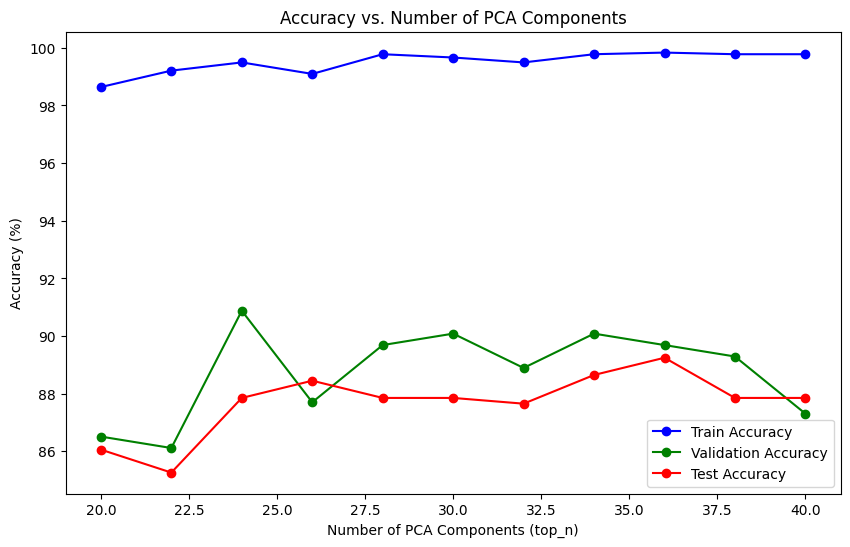

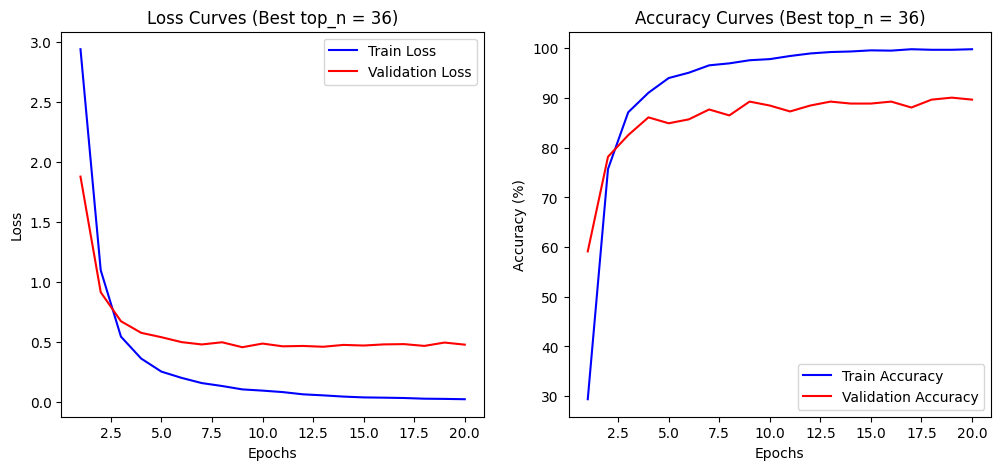

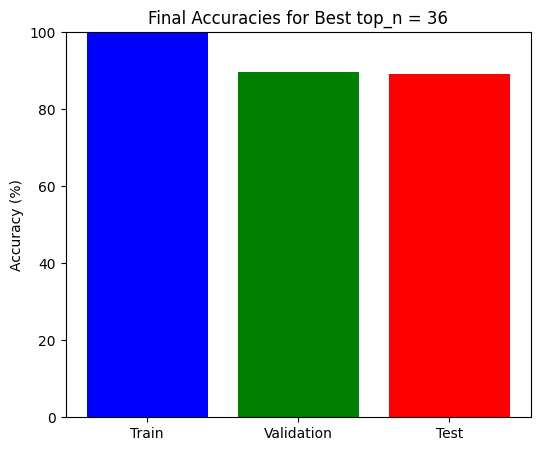

Best Accuracies at top_n = 36
Train Accuracy: 99.83%
Validation Accuracy: 89.68%
Test Accuracy: 89.24%


In [ ]:
#Changing the values of random state

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# PCA Implementation


def standardise_data(dataset, mean=None, std_dev=None):
    if mean is None or std_dev is None:
        mean = np.mean(dataset, axis=0)
        std_dev = np.std(dataset, axis=0)
    std_data = (dataset - mean) / std_dev
    return std_data, mean, std_dev

def covariance_matrix(dataset):
    m = dataset.shape[0]  # number of samples
    cov_matrix = np.dot(dataset.T, dataset) / (m - 1)
    return cov_matrix

def eigenvalues_eigenvectors(cov_matrix):
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    return eigenvalues, eigenvectors

def sort_eigenpairs(eigenvalues, eigenvectors):
    sorted_indices = np.argsort(eigenvalues)[::-1]  # descending order
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvalues, sorted_eigenvectors

def project_dataset_to_new_plane(X, eigenvectors, top_n=1):
    W = eigenvectors[:, :top_n]
    projected_data = np.dot(X, W)
    return projected_data

# Definition of the MLP model (ReLU is used as Activation function)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=50):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


X = np.load("X_features.npy")
y = np.load("y_labels.npy")

# Split: 70% Train, 30% Temp, then split Temp into Test (20%) and Validation (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=7)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=7)


X_train_std, train_mean, train_std = standardise_data(X_train)
X_val_std, _, _ = standardise_data(X_val, train_mean, train_std)
X_test_std, _, _ = standardise_data(X_test, train_mean, train_std)

# Loop over different top_n values for PCA

top_n_values = list(range(20, 41, 2))
final_train_accs = []
final_val_accs = []
final_test_accs = []

# To store epoch-wise curves for best model (highest test accuracy)
best_test_acc = -1
best_top_n = None
best_epoch_train_losses = None
best_epoch_val_losses = None
best_epoch_train_accs = None
best_epoch_val_accs = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 20
batch_size = 32

for top_n in top_n_values:
    # Compute PCA on training data
    cov_mat = covariance_matrix(X_train_std)
    eigvals, eigvecs = eigenvalues_eigenvectors(cov_mat)
    sorted_eigvals, sorted_eigvecs = sort_eigenpairs(eigvals, eigvecs)

    # Project datasets to new space with top_n components
    X_train_proj = project_dataset_to_new_plane(X_train_std, sorted_eigvecs, top_n=top_n)
    X_val_proj   = project_dataset_to_new_plane(X_val_std, sorted_eigvecs, top_n=top_n)
    X_test_proj  = project_dataset_to_new_plane(X_test_std, sorted_eigvecs, top_n=top_n)

    # Create PyTorch tensors and datasets
    X_train_tensor = torch.tensor(X_train_proj, dtype=torch.float32)
    X_val_tensor   = torch.tensor(X_val_proj, dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test_proj, dtype=torch.float32)

    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_val_tensor   = torch.tensor(y_val, dtype=torch.long)
    y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    
    model = MLP(input_size=top_n).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Store epoch-wise loss and accuracy curves for this top_n
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accs = []
    epoch_val_accs = []

    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
        train_loss = total_loss / len(train_loader)
        train_acc = correct * 100 / total

        epoch_train_losses.append(train_loss)
        epoch_train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)
                val_correct += (predicted == batch_y).sum().item()
                val_total += batch_y.size(0)
        val_loss_avg = val_loss / len(val_loader)
        val_acc = val_correct * 100 / val_total

        epoch_val_losses.append(val_loss_avg)
        epoch_val_accs.append(val_acc)

    # Evaluate on test set after training
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            predicted = torch.argmax(outputs, dim=1)
            test_correct += (predicted == batch_y).sum().item()
            test_total += batch_y.size(0)
    test_acc = test_correct * 100 / test_total

    final_train_accs.append(epoch_train_accs[-1])
    final_val_accs.append(epoch_val_accs[-1])
    final_test_accs.append(test_acc)

    print(f"Top_n = {top_n}: Final Train Acc = {epoch_train_accs[-1]:.2f}%, Val Acc = {epoch_val_accs[-1]:.2f}%, Test Acc = {test_acc:.2f}%")

    # If this top_n gives the best test accuracy till this point, store its epoch curves
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_top_n = top_n
        best_epoch_train_losses = epoch_train_losses
        best_epoch_val_losses = epoch_val_losses
        best_epoch_train_accs = epoch_train_accs
        best_epoch_val_accs = epoch_val_accs

# Plotting:Accuracy vs top_n

plt.figure(figsize=(10, 6))
plt.plot(top_n_values, final_train_accs, label="Train Accuracy", marker="o", color="blue")
plt.plot(top_n_values, final_val_accs, label="Validation Accuracy", marker="o", color="green")
plt.plot(top_n_values, final_test_accs, label="Test Accuracy", marker="o", color="red")
plt.xlabel("Number of PCA Components (top_n)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Number of PCA Components")
plt.legend()
plt.show()

# Plotting:Epoch-wise Loss and Accuracy curves for best top_n

plt.figure(figsize=(12, 5))
# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), best_epoch_train_losses, label="Train Loss", color="blue")
plt.plot(range(1, num_epochs+1), best_epoch_val_losses, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Loss Curves (Best top_n = {best_top_n})")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), best_epoch_train_accs, label="Train Accuracy", color="blue")
plt.plot(range(1, num_epochs+1), best_epoch_val_accs, label="Validation Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title(f"Accuracy Curves (Best top_n = {best_top_n})")
plt.legend()
plt.show()

# Bar Chart for Best Final Accuracies at Best top_n

labels = ["Train", "Validation", "Test"]
best_train_acc = best_epoch_train_accs[-1]
best_val_acc = best_epoch_val_accs[-1]
best_test_acc_final = best_test_acc

plt.figure(figsize=(6, 5))
plt.bar(labels, [best_train_acc, best_val_acc, best_test_acc_final], color=["blue", "green", "red"])
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title(f"Final Accuracies for Best top_n = {best_top_n}")
plt.show()

print("Best Accuracies at top_n =", best_top_n)
print(f"Train Accuracy: {best_train_acc:.2f}%")
print(f"Validation Accuracy: {best_val_acc:.2f}%")
print(f"Test Accuracy: {best_test_acc_final:.2f}%")

Top_n = 150: Final Train Acc = 99.77%, Val Acc = 88.49%, Test Acc = 89.64%


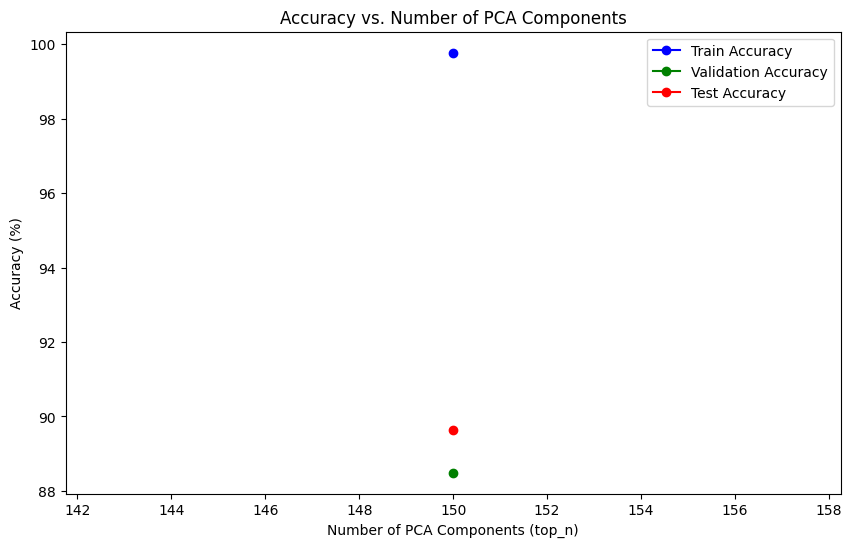

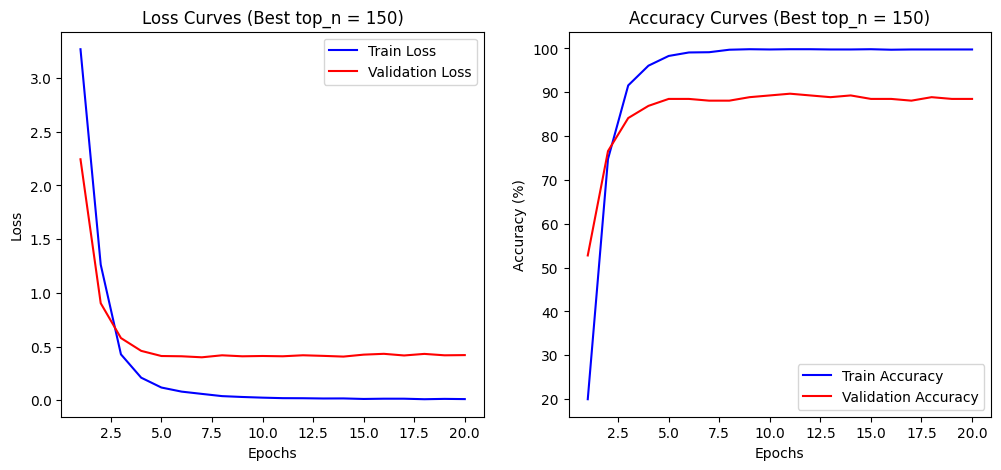

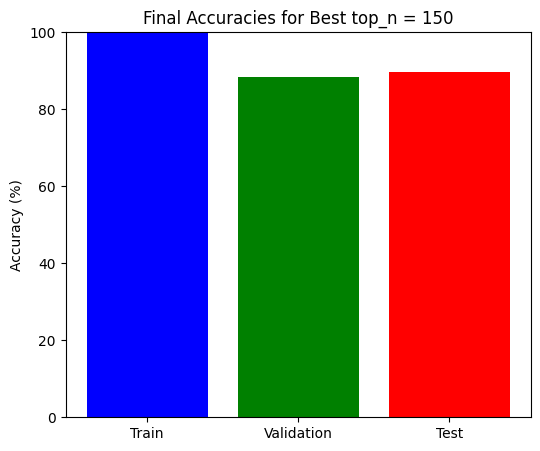

Best Accuracies at top_n = 150
Train Accuracy: 99.77%
Validation Accuracy: 88.49%
Test Accuracy: 89.64%


In [ ]:
#Changing the values of random state

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# PCA Implementation

def standardise_data(dataset, mean=None, std_dev=None):
    if mean is None or std_dev is None:
        mean = np.mean(dataset, axis=0)
        std_dev = np.std(dataset, axis=0)
    std_data = (dataset - mean) / std_dev
    return std_data, mean, std_dev

def covariance_matrix(dataset):
    m = dataset.shape[0]  # number of samples
    cov_matrix = np.dot(dataset.T, dataset) / (m - 1)
    return cov_matrix

def eigenvalues_eigenvectors(cov_matrix):
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    return eigenvalues, eigenvectors

def sort_eigenpairs(eigenvalues, eigenvectors):
    sorted_indices = np.argsort(eigenvalues)[::-1]  # descending order
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvalues, sorted_eigenvectors

def project_dataset_to_new_plane(X, eigenvectors, top_n=1):
    W = eigenvectors[:, :top_n]
    projected_data = np.dot(X, W)
    return projected_data


# Definition of the MLP model (ReLU is used as Activation function)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=50):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x




X = np.load("X_features.npy")
y = np.load("y_labels.npy")

# Split: 70% Train, 30% Temp, then split Temp into Test (20%) and Validation (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=7) #Random state is now set to 7
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=7)




X_train_std, train_mean, train_std = standardise_data(X_train)
X_val_std, _, _ = standardise_data(X_val, train_mean, train_std)
X_test_std, _, _ = standardise_data(X_test, train_mean, train_std)


# Loop over different top_n values for PCA

top_n_values = list(range(150, 151, 2))
final_train_accs = []
final_val_accs = []
final_test_accs = []

# To store epoch-wise curves for best model (highest test accuracy)
best_test_acc = -1
best_top_n = None
best_epoch_train_losses = None
best_epoch_val_losses = None
best_epoch_train_accs = None
best_epoch_val_accs = None


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 20
batch_size = 32

for top_n in top_n_values:
    # Compute PCA on training data
    cov_mat = covariance_matrix(X_train_std)
    eigvals, eigvecs = eigenvalues_eigenvectors(cov_mat)
    sorted_eigvals, sorted_eigvecs = sort_eigenpairs(eigvals, eigvecs)

    # Project datasets to new space with top_n components
    X_train_proj = project_dataset_to_new_plane(X_train_std, sorted_eigvecs, top_n=top_n)
    X_val_proj   = project_dataset_to_new_plane(X_val_std, sorted_eigvecs, top_n=top_n)
    X_test_proj  = project_dataset_to_new_plane(X_test_std, sorted_eigvecs, top_n=top_n)

    # Create PyTorch tensors and datasets
    X_train_tensor = torch.tensor(X_train_proj, dtype=torch.float32)
    X_val_tensor   = torch.tensor(X_val_proj, dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test_proj, dtype=torch.float32)

    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_val_tensor   = torch.tensor(y_val, dtype=torch.long)
    y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    
    model = MLP(input_size=top_n).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Store epoch-wise loss and accuracy curves for this top_n
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accs = []
    epoch_val_accs = []

    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
        train_loss = total_loss / len(train_loader)
        train_acc = correct * 100 / total

        epoch_train_losses.append(train_loss)
        epoch_train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)
                val_correct += (predicted == batch_y).sum().item()
                val_total += batch_y.size(0)
        val_loss_avg = val_loss / len(val_loader)
        val_acc = val_correct * 100 / val_total

        epoch_val_losses.append(val_loss_avg)
        epoch_val_accs.append(val_acc)

    # Evaluate on test set after training
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            predicted = torch.argmax(outputs, dim=1)
            test_correct += (predicted == batch_y).sum().item()
            test_total += batch_y.size(0)
    test_acc = test_correct * 100 / test_total

    final_train_accs.append(epoch_train_accs[-1])
    final_val_accs.append(epoch_val_accs[-1])
    final_test_accs.append(test_acc)

    print(f"Top_n = {top_n}: Final Train Acc = {epoch_train_accs[-1]:.2f}%, Val Acc = {epoch_val_accs[-1]:.2f}%, Test Acc = {test_acc:.2f}%")

    # If this top_n gives the best test accuracy till this point, store its epoch curves
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_top_n = top_n
        best_epoch_train_losses = epoch_train_losses
        best_epoch_val_losses = epoch_val_losses
        best_epoch_train_accs = epoch_train_accs
        best_epoch_val_accs = epoch_val_accs


# Plotting: Accuracy vs top_n

plt.figure(figsize=(10, 6))
plt.plot(top_n_values, final_train_accs, label="Train Accuracy", marker="o", color="blue")
plt.plot(top_n_values, final_val_accs, label="Validation Accuracy", marker="o", color="green")
plt.plot(top_n_values, final_test_accs, label="Test Accuracy", marker="o", color="red")
plt.xlabel("Number of PCA Components (top_n)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Number of PCA Components")
plt.legend()
plt.show()


# Plotting: Epoch-wise Loss and Accuracy curves for best top_n

plt.figure(figsize=(12, 5))
# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), best_epoch_train_losses, label="Train Loss", color="blue")
plt.plot(range(1, num_epochs+1), best_epoch_val_losses, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Loss Curves (Best top_n = {best_top_n})")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), best_epoch_train_accs, label="Train Accuracy", color="blue")
plt.plot(range(1, num_epochs+1), best_epoch_val_accs, label="Validation Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title(f"Accuracy Curves (Best top_n = {best_top_n})")
plt.legend()
plt.show()


# Bar Chart for Best Final Accuracies at Best top_n

labels = ["Train", "Validation", "Test"]
best_train_acc = best_epoch_train_accs[-1]
best_val_acc = best_epoch_val_accs[-1]
best_test_acc_final = best_test_acc

plt.figure(figsize=(6, 5))
plt.bar(labels, [best_train_acc, best_val_acc, best_test_acc_final], color=["blue", "green", "red"])
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title(f"Final Accuracies for Best top_n = {best_top_n}")
plt.show()

print("Best Accuracies at top_n =", best_top_n)
print(f"Train Accuracy: {best_train_acc:.2f}%")
print(f"Validation Accuracy: {best_val_acc:.2f}%")
print(f"Test Accuracy: {best_test_acc_final:.2f}%")

Top_n = 150: Final Train Acc = 99.73%, Val Acc = 88.49%, Test Acc = 87.25%


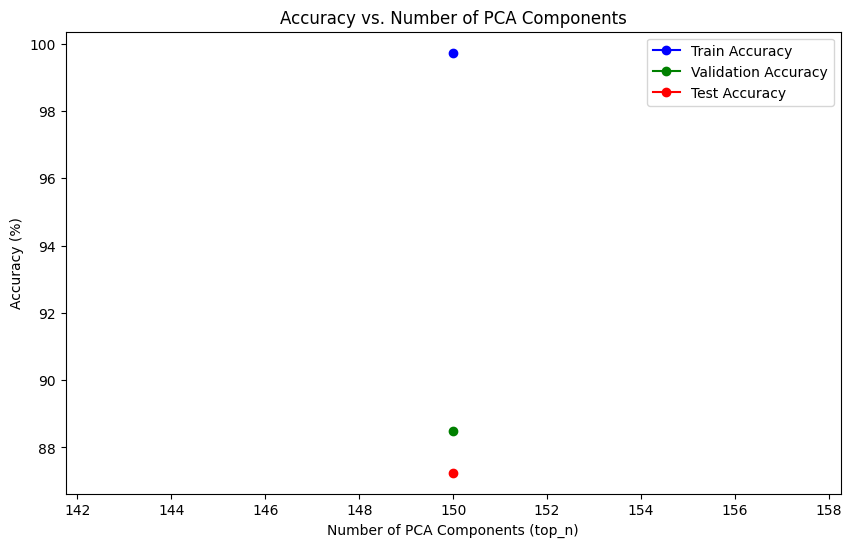

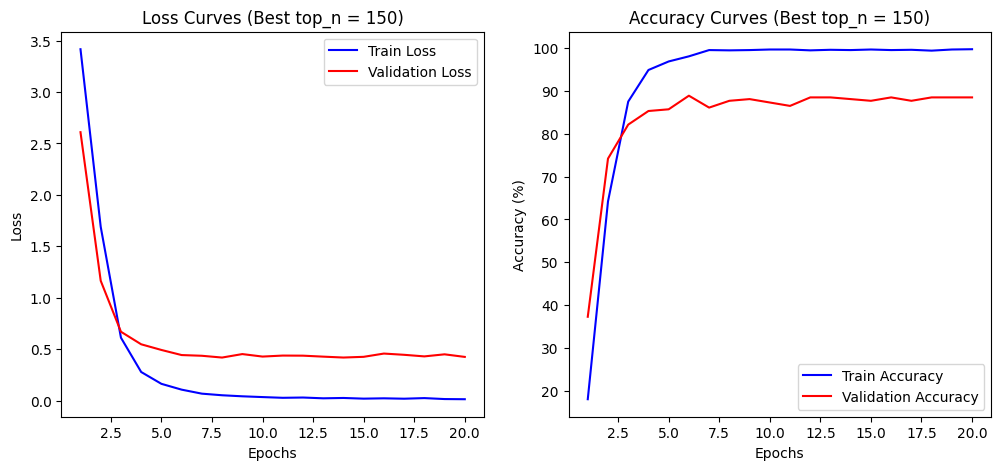

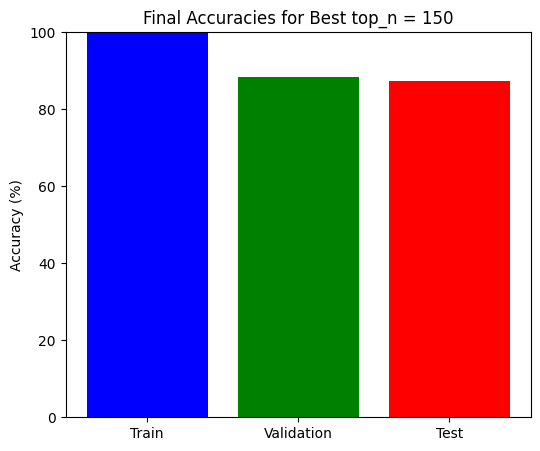

Best Accuracies at top_n = 150
Train Accuracy: 99.73%
Validation Accuracy: 88.49%
Test Accuracy: 87.25%


In [ ]:
#Changing the split

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


# PCA Implementation


def standardise_data(dataset, mean=None, std_dev=None):
    if mean is None or std_dev is None:
        mean = np.mean(dataset, axis=0)
        std_dev = np.std(dataset, axis=0)
    std_data = (dataset - mean) / std_dev
    return std_data, mean, std_dev

def covariance_matrix(dataset):
    m = dataset.shape[0]  # number of samples
    cov_matrix = np.dot(dataset.T, dataset) / (m - 1)
    return cov_matrix

def eigenvalues_eigenvectors(cov_matrix):
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    return eigenvalues, eigenvectors

def sort_eigenpairs(eigenvalues, eigenvectors):
    sorted_indices = np.argsort(eigenvalues)[::-1]  # descending order
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvalues, sorted_eigenvectors

def project_dataset_to_new_plane(X, eigenvectors, top_n=1):
    W = eigenvectors[:, :top_n]
    projected_data = np.dot(X, W)
    return projected_data


# Definition of the MLP model (ReLU is used as Activation function)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=50):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


X = np.load("X_features.npy")
y = np.load("y_labels.npy")

# Split: 60% Train, 40% Temp, then split Temp into Test (30%) and Validation (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/4, stratify=y_temp, random_state=42)




X_train_std, train_mean, train_std = standardise_data(X_train)
X_val_std, _, _ = standardise_data(X_val, train_mean, train_std)
X_test_std, _, _ = standardise_data(X_test, train_mean, train_std)


# Loop over different top_n values for PCA

top_n_values = list(range(150, 151, 2))
final_train_accs = []
final_val_accs = []
final_test_accs = []

# To store epoch-wise curves for best model (highest test accuracy)
best_test_acc = -1
best_top_n = None
best_epoch_train_losses = None
best_epoch_val_losses = None
best_epoch_train_accs = None
best_epoch_val_accs = None


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 20
batch_size = 32

for top_n in top_n_values:
    # Compute PCA on training data
    cov_mat = covariance_matrix(X_train_std)
    eigvals, eigvecs = eigenvalues_eigenvectors(cov_mat)
    sorted_eigvals, sorted_eigvecs = sort_eigenpairs(eigvals, eigvecs)

    # Project datasets to new space with top_n components
    X_train_proj = project_dataset_to_new_plane(X_train_std, sorted_eigvecs, top_n=top_n)
    X_val_proj   = project_dataset_to_new_plane(X_val_std, sorted_eigvecs, top_n=top_n)
    X_test_proj  = project_dataset_to_new_plane(X_test_std, sorted_eigvecs, top_n=top_n)

    # Create PyTorch tensors and datasets
    X_train_tensor = torch.tensor(X_train_proj, dtype=torch.float32)
    X_val_tensor   = torch.tensor(X_val_proj, dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test_proj, dtype=torch.float32)

    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_val_tensor   = torch.tensor(y_val, dtype=torch.long)
    y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    
    model = MLP(input_size=top_n).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Store epoch-wise loss and accuracy curves for this top_n
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accs = []
    epoch_val_accs = []

    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
        train_loss = total_loss / len(train_loader)
        train_acc = correct * 100 / total

        epoch_train_losses.append(train_loss)
        epoch_train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)
                val_correct += (predicted == batch_y).sum().item()
                val_total += batch_y.size(0)
        val_loss_avg = val_loss / len(val_loader)
        val_acc = val_correct * 100 / val_total

        epoch_val_losses.append(val_loss_avg)
        epoch_val_accs.append(val_acc)

    # Evaluate on test set after training
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            predicted = torch.argmax(outputs, dim=1)
            test_correct += (predicted == batch_y).sum().item()
            test_total += batch_y.size(0)
    test_acc = test_correct * 100 / test_total

    final_train_accs.append(epoch_train_accs[-1])
    final_val_accs.append(epoch_val_accs[-1])
    final_test_accs.append(test_acc)

    print(f"Top_n = {top_n}: Final Train Acc = {epoch_train_accs[-1]:.2f}%, Val Acc = {epoch_val_accs[-1]:.2f}%, Test Acc = {test_acc:.2f}%")

    # If this top_n gives the best test accuracy till this point, store its epoch curves
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_top_n = top_n
        best_epoch_train_losses = epoch_train_losses
        best_epoch_val_losses = epoch_val_losses
        best_epoch_train_accs = epoch_train_accs
        best_epoch_val_accs = epoch_val_accs


# Plotting: Accuracy vs top_n

plt.figure(figsize=(10, 6))
plt.plot(top_n_values, final_train_accs, label="Train Accuracy", marker="o", color="blue")
plt.plot(top_n_values, final_val_accs, label="Validation Accuracy", marker="o", color="green")
plt.plot(top_n_values, final_test_accs, label="Test Accuracy", marker="o", color="red")
plt.xlabel("Number of PCA Components (top_n)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Number of PCA Components")
plt.legend()
plt.show()


# Plotting: Epoch-wise Loss and Accuracy curves for best top_n

plt.figure(figsize=(12, 5))
# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), best_epoch_train_losses, label="Train Loss", color="blue")
plt.plot(range(1, num_epochs+1), best_epoch_val_losses, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Loss Curves (Best top_n = {best_top_n})")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), best_epoch_train_accs, label="Train Accuracy", color="blue")
plt.plot(range(1, num_epochs+1), best_epoch_val_accs, label="Validation Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title(f"Accuracy Curves (Best top_n = {best_top_n})")
plt.legend()
plt.show()


# Bar Chart for Best Final Accuracies at Best top_n

labels = ["Train", "Validation", "Test"]
best_train_acc = best_epoch_train_accs[-1]
best_val_acc = best_epoch_val_accs[-1]
best_test_acc_final = best_test_acc

plt.figure(figsize=(6, 5))
plt.bar(labels, [best_train_acc, best_val_acc, best_test_acc_final], color=["blue", "green", "red"])
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title(f"Final Accuracies for Best top_n = {best_top_n}")
plt.show()

print("Best Accuracies at top_n =", best_top_n)
print(f"Train Accuracy: {best_train_acc:.2f}%")
print(f"Validation Accuracy: {best_val_acc:.2f}%")
print(f"Test Accuracy: {best_test_acc_final:.2f}%")

Top_n = 145: Final Train Acc = 99.67%, Val Acc = 88.49%, Test Acc = 88.31%


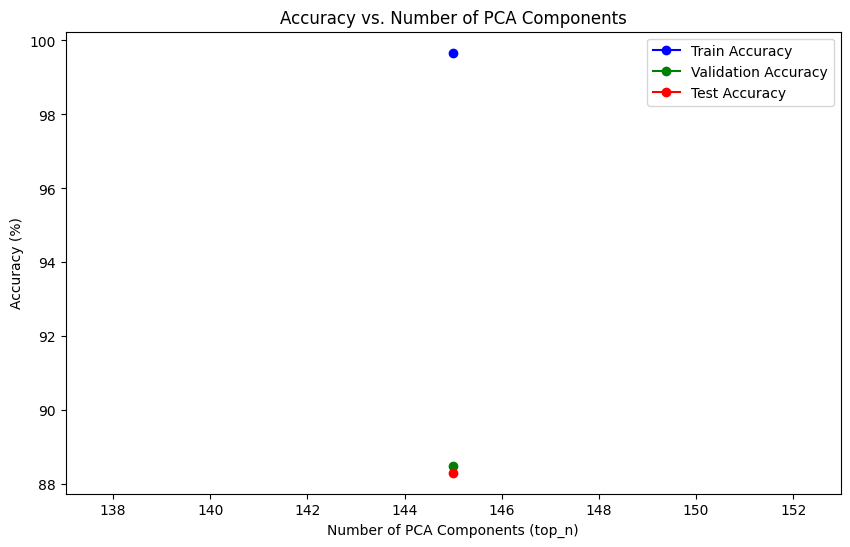

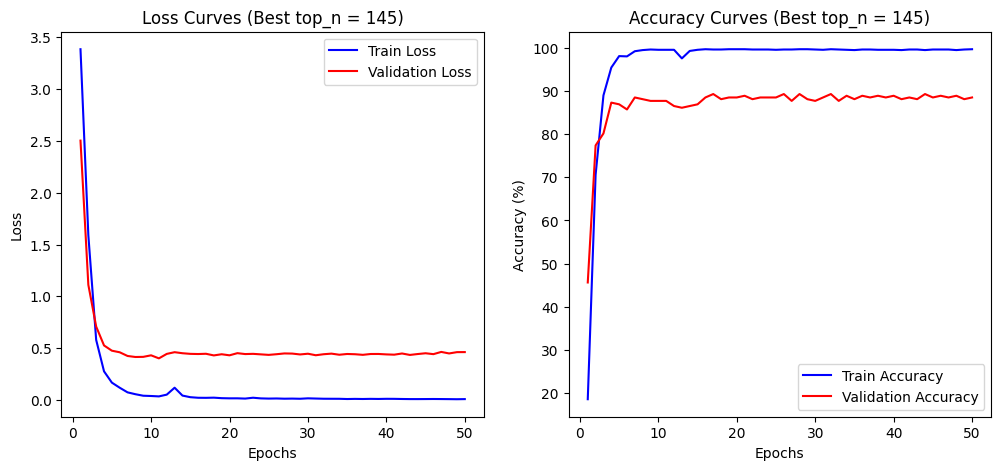

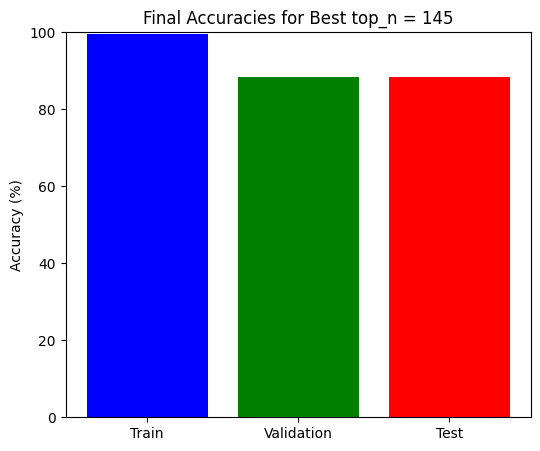

Best Accuracies at top_n = 145
Train Accuracy: 99.67%
Validation Accuracy: 88.49%
Test Accuracy: 88.31%


In [ ]:
#Changing epochs

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


# PCA Implementation


def standardise_data(dataset, mean=None, std_dev=None):
    if mean is None or std_dev is None:
        mean = np.mean(dataset, axis=0)
        std_dev = np.std(dataset, axis=0)
    std_data = (dataset - mean) / std_dev
    return std_data, mean, std_dev

def covariance_matrix(dataset):
    m = dataset.shape[0]  # number of samples
    cov_matrix = np.dot(dataset.T, dataset) / (m - 1)
    return cov_matrix

def eigenvalues_eigenvectors(cov_matrix):
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    return eigenvalues, eigenvectors

def sort_eigenpairs(eigenvalues, eigenvectors):
    sorted_indices = np.argsort(eigenvalues)[::-1]  # descending order
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvalues, sorted_eigenvectors

def project_dataset_to_new_plane(X, eigenvectors, top_n=1):
    W = eigenvectors[:, :top_n]
    projected_data = np.dot(X, W)
    return projected_data


# Definition of the MLP model (ReLU is used as Activation function)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=50):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x




X = np.load("X_features.npy")
y = np.load("y_labels.npy")

# Split: 60% Train, 40% Temp, then split Temp into Test (30%) and Validation (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/4, stratify=y_temp, random_state=42)




X_train_std, train_mean, train_std = standardise_data(X_train)
X_val_std, _, _ = standardise_data(X_val, train_mean, train_std)
X_test_std, _, _ = standardise_data(X_test, train_mean, train_std)


# Loop over different top_n values for PCA

top_n_values = list(range(145, 146, 1))
final_train_accs = []
final_val_accs = []
final_test_accs = []

# To store epoch-wise curves for best model (highest test accuracy)
best_test_acc = -1
best_top_n = None
best_epoch_train_losses = None
best_epoch_val_losses = None
best_epoch_train_accs = None
best_epoch_val_accs = None


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 50
batch_size = 32

for top_n in top_n_values:
    # Compute PCA on training data
    cov_mat = covariance_matrix(X_train_std)
    eigvals, eigvecs = eigenvalues_eigenvectors(cov_mat)
    sorted_eigvals, sorted_eigvecs = sort_eigenpairs(eigvals, eigvecs)

    # Project datasets to new space with top_n components
    X_train_proj = project_dataset_to_new_plane(X_train_std, sorted_eigvecs, top_n=top_n)
    X_val_proj   = project_dataset_to_new_plane(X_val_std, sorted_eigvecs, top_n=top_n)
    X_test_proj  = project_dataset_to_new_plane(X_test_std, sorted_eigvecs, top_n=top_n)

    # Create PyTorch tensors and datasets
    X_train_tensor = torch.tensor(X_train_proj, dtype=torch.float32)
    X_val_tensor   = torch.tensor(X_val_proj, dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test_proj, dtype=torch.float32)

    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_val_tensor   = torch.tensor(y_val, dtype=torch.long)
    y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    
    model = MLP(input_size=top_n).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Store epoch-wise loss and accuracy curves for this top_n
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accs = []
    epoch_val_accs = []

    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
        train_loss = total_loss / len(train_loader)
        train_acc = correct * 100 / total

        epoch_train_losses.append(train_loss)
        epoch_train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)
                val_correct += (predicted == batch_y).sum().item()
                val_total += batch_y.size(0)
        val_loss_avg = val_loss / len(val_loader)
        val_acc = val_correct * 100 / val_total

        epoch_val_losses.append(val_loss_avg)
        epoch_val_accs.append(val_acc)

    # Evaluate on test set after training
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            predicted = torch.argmax(outputs, dim=1)
            test_correct += (predicted == batch_y).sum().item()
            test_total += batch_y.size(0)
    test_acc = test_correct * 100 / test_total

    final_train_accs.append(epoch_train_accs[-1])
    final_val_accs.append(epoch_val_accs[-1])
    final_test_accs.append(test_acc)

    print(f"Top_n = {top_n}: Final Train Acc = {epoch_train_accs[-1]:.2f}%, Val Acc = {epoch_val_accs[-1]:.2f}%, Test Acc = {test_acc:.2f}%")

    # If this top_n gives the best test accuracy till this point, store its epoch curves
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_top_n = top_n
        best_epoch_train_losses = epoch_train_losses
        best_epoch_val_losses = epoch_val_losses
        best_epoch_train_accs = epoch_train_accs
        best_epoch_val_accs = epoch_val_accs


# Plotting: Accuracy vs top_n

plt.figure(figsize=(10, 6))
plt.plot(top_n_values, final_train_accs, label="Train Accuracy", marker="o", color="blue")
plt.plot(top_n_values, final_val_accs, label="Validation Accuracy", marker="o", color="green")
plt.plot(top_n_values, final_test_accs, label="Test Accuracy", marker="o", color="red")
plt.xlabel("Number of PCA Components (top_n)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Number of PCA Components")
plt.legend()
plt.show()


# Plotting: Epoch-wise Loss and Accuracy curves for best top_n

plt.figure(figsize=(12, 5))
# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), best_epoch_train_losses, label="Train Loss", color="blue")
plt.plot(range(1, num_epochs+1), best_epoch_val_losses, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Loss Curves (Best top_n = {best_top_n})")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), best_epoch_train_accs, label="Train Accuracy", color="blue")
plt.plot(range(1, num_epochs+1), best_epoch_val_accs, label="Validation Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title(f"Accuracy Curves (Best top_n = {best_top_n})")
plt.legend()
plt.show()


# Bar Chart for Best Final Accuracies at Best top_n

labels = ["Train", "Validation", "Test"]
best_train_acc = best_epoch_train_accs[-1]
best_val_acc = best_epoch_val_accs[-1]
best_test_acc_final = best_test_acc

plt.figure(figsize=(6, 5))
plt.bar(labels, [best_train_acc, best_val_acc, best_test_acc_final], color=["blue", "green", "red"])
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title(f"Final Accuracies for Best top_n = {best_top_n}")
plt.show()

print("Best Accuracies at top_n =", best_top_n)
print(f"Train Accuracy: {best_train_acc:.2f}%")
print(f"Validation Accuracy: {best_val_acc:.2f}%")
print(f"Test Accuracy: {best_test_acc_final:.2f}%")

top_n = 3: Final Train Acc = 56.57%, Val Acc = 48.02%, Test Acc = 46.81%
top_n = 4: Final Train Acc = 72.40%, Val Acc = 59.92%, Test Acc = 57.77%
top_n = 5: Final Train Acc = 79.62%, Val Acc = 59.13%, Test Acc = 55.98%
top_n = 6: Final Train Acc = 86.68%, Val Acc = 59.92%, Test Acc = 58.57%
top_n = 7: Final Train Acc = 92.60%, Val Acc = 63.10%, Test Acc = 65.14%
top_n = 8: Final Train Acc = 95.67%, Val Acc = 68.65%, Test Acc = 68.92%
top_n = 9: Final Train Acc = 95.11%, Val Acc = 73.41%, Test Acc = 72.91%
top_n = 10: Final Train Acc = 96.76%, Val Acc = 73.81%, Test Acc = 76.49%
top_n = 11: Final Train Acc = 98.12%, Val Acc = 73.81%, Test Acc = 74.10%
top_n = 12: Final Train Acc = 98.52%, Val Acc = 78.17%, Test Acc = 77.49%
top_n = 13: Final Train Acc = 99.43%, Val Acc = 78.17%, Test Acc = 79.88%
top_n = 14: Final Train Acc = 99.37%, Val Acc = 79.76%, Test Acc = 84.06%
top_n = 15: Final Train Acc = 99.54%, Val Acc = 82.94%, Test Acc = 82.47%
top_n = 16: Final Train Acc = 99.60%, Val Acc

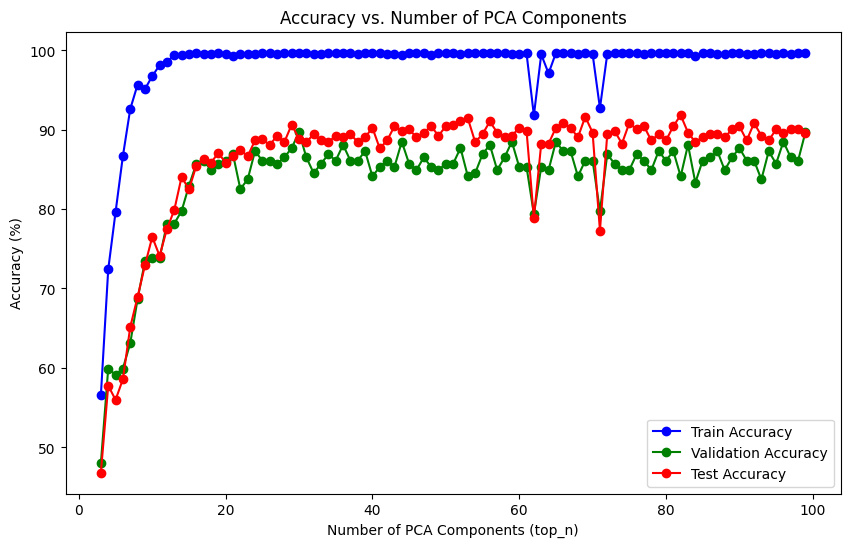


Final Accuracies for each top_n:
top_n = 3: Train Acc = 56.57%, Val Acc = 48.02%, Test Acc = 46.81%
top_n = 4: Train Acc = 72.40%, Val Acc = 59.92%, Test Acc = 57.77%
top_n = 5: Train Acc = 79.62%, Val Acc = 59.13%, Test Acc = 55.98%
top_n = 6: Train Acc = 86.68%, Val Acc = 59.92%, Test Acc = 58.57%
top_n = 7: Train Acc = 92.60%, Val Acc = 63.10%, Test Acc = 65.14%
top_n = 8: Train Acc = 95.67%, Val Acc = 68.65%, Test Acc = 68.92%
top_n = 9: Train Acc = 95.11%, Val Acc = 73.41%, Test Acc = 72.91%
top_n = 10: Train Acc = 96.76%, Val Acc = 73.81%, Test Acc = 76.49%
top_n = 11: Train Acc = 98.12%, Val Acc = 73.81%, Test Acc = 74.10%
top_n = 12: Train Acc = 98.52%, Val Acc = 78.17%, Test Acc = 77.49%
top_n = 13: Train Acc = 99.43%, Val Acc = 78.17%, Test Acc = 79.88%
top_n = 14: Train Acc = 99.37%, Val Acc = 79.76%, Test Acc = 84.06%
top_n = 15: Train Acc = 99.54%, Val Acc = 82.94%, Test Acc = 82.47%
top_n = 16: Train Acc = 99.60%, Val Acc = 85.71%, Test Acc = 85.46%
top_n = 17: Train Acc

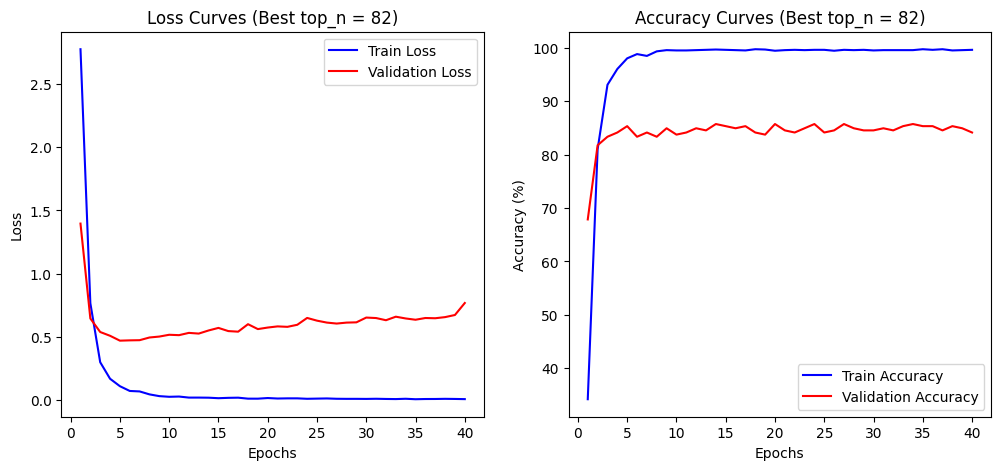

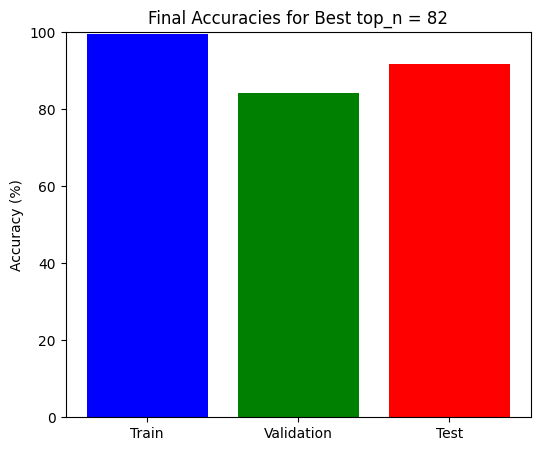


Best Accuracies:
Best top_n: 82
Train Accuracy: 99.60%
Validation Accuracy: 84.13%
Test Accuracy: 91.83%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


# PCA Implementation

def standardise_data(dataset, mean=None, std_dev=None):
    if mean is None or std_dev is None:
        mean = np.mean(dataset, axis=0)
        std_dev = np.std(dataset, axis=0)
    std_data = (dataset - mean) / std_dev
    return std_data, mean, std_dev

def covariance_matrix(dataset):
    m = dataset.shape[0]  # number of samples
    cov_matrix = np.dot(dataset.T, dataset) / (m - 1)
    return cov_matrix

def eigenvalues_eigenvectors(cov_matrix):
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    return eigenvalues, eigenvectors

def sort_eigenpairs(eigenvalues, eigenvectors):
    sorted_indices = np.argsort(eigenvalues)[::-1]  # descending order
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvalues, sorted_eigenvectors

def project_dataset_to_new_plane(X, eigenvectors, top_n=1):
    W = eigenvectors[:, :top_n]
    projected_data = np.dot(X, W)
    return projected_data


# Definition of the MLP model (ReLU is used as Activation function)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=50):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


X = np.load("X_features.npy")
y = np.load("y_labels.npy")

# Split: 70% Train, 30% Temp, then split Temp into Test (20%) and Validation (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42)




X_train_std, train_mean, train_std = standardise_data(X_train)
X_val_std, _, _ = standardise_data(X_val, train_mean, train_std)
X_test_std, _, _ = standardise_data(X_test, train_mean, train_std)


# Compute PCA(on training set)

cov_mat = covariance_matrix(X_train_std)
eigvals, eigvecs = eigenvalues_eigenvectors(cov_mat)
sorted_eigvals, sorted_eigvecs = sort_eigenpairs(eigvals, eigvecs)


# Loop over different top_n values for PCA

top_n_values = list(range(3, 100, 1))
final_train_accs, final_val_accs, final_test_accs = [], [], []

best_test_acc = -1
best_top_n = None
best_epoch_train_losses, best_epoch_val_losses = None, None
best_epoch_train_accs, best_epoch_val_accs = None, None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs, batch_size = 40, 16

for top_n in top_n_values:
    # Project datasets to new space using precomputed PCA components
    X_train_proj = project_dataset_to_new_plane(X_train_std, sorted_eigvecs, top_n=top_n)
    X_val_proj = project_dataset_to_new_plane(X_val_std, sorted_eigvecs, top_n=top_n)
    X_test_proj = project_dataset_to_new_plane(X_test_std, sorted_eigvecs, top_n=top_n)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_proj, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_proj, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_proj, dtype=torch.float32)

    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    
    model = MLP(input_size=top_n).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epoch_train_losses, epoch_val_losses = [], []
    epoch_train_accs, epoch_val_accs = [], []

    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
        train_loss = total_loss / len(train_loader)
        train_acc = correct * 100 / total

        epoch_train_losses.append(train_loss)
        epoch_train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)
                val_correct += (predicted == batch_y).sum().item()
                val_total += batch_y.size(0)
        val_loss_avg = val_loss / len(val_loader)
        val_acc = val_correct * 100 / val_total

        epoch_val_losses.append(val_loss_avg)
        epoch_val_accs.append(val_acc)

    # Evaluate on test set after training
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            predicted = torch.argmax(outputs, dim=1)
            test_correct += (predicted == batch_y).sum().item()
            test_total += batch_y.size(0)
    test_acc = test_correct * 100 / test_total

    final_train_accs.append(epoch_train_accs[-1])
    final_val_accs.append(epoch_val_accs[-1])
    final_test_accs.append(test_acc)

    print(f"top_n = {top_n}: Final Train Acc = {epoch_train_accs[-1]:.2f}%, Val Acc = {epoch_val_accs[-1]:.2f}%, Test Acc = {test_acc:.2f}%")

    # If this top_n gives the best test accuracy till this point, store its epoch curves
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_top_n = top_n
        best_epoch_train_losses = epoch_train_losses
        best_epoch_val_losses = epoch_val_losses
        best_epoch_train_accs = epoch_train_accs
        best_epoch_val_accs = epoch_val_accs


# Plotting: Accuracy vs top_n

plt.figure(figsize=(10, 6))
plt.plot(top_n_values, final_train_accs, label="Train Accuracy", marker="o", color="blue")
plt.plot(top_n_values, final_val_accs, label="Validation Accuracy", marker="o", color="green")
plt.plot(top_n_values, final_test_accs, label="Test Accuracy", marker="o", color="red")
plt.xlabel("Number of PCA Components (top_n)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Number of PCA Components")
plt.legend()
plt.show()


# Print All Final Accuracies for each top_n

print("\nFinal Accuracies for each top_n:")
for i, top_n in enumerate(top_n_values):
    print(f"top_n = {top_n}: Train Acc = {final_train_accs[i]:.2f}%, Val Acc = {final_val_accs[i]:.2f}%, Test Acc = {final_test_accs[i]:.2f}%")


# Plotting: Epoch-wise Loss and Accuracy curves for best top_n

plt.figure(figsize=(12, 5))
# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), best_epoch_train_losses, label="Train Loss", color="blue")
plt.plot(range(1, num_epochs+1), best_epoch_val_losses, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Loss Curves (Best top_n = {best_top_n})")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), best_epoch_train_accs, label="Train Accuracy", color="blue")
plt.plot(range(1, num_epochs+1), best_epoch_val_accs, label="Validation Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title(f"Accuracy Curves (Best top_n = {best_top_n})")
plt.legend()
plt.show()


# Bar Chart for Best Final Accuracies at Best top_n

labels = ["Train", "Validation", "Test"]
best_train_acc = best_epoch_train_accs[-1]
best_val_acc = best_epoch_val_accs[-1]
best_test_acc_final = best_test_acc

plt.figure(figsize=(6, 5))
plt.bar(labels, [best_train_acc, best_val_acc, best_test_acc_final], color=["blue", "green", "red"])
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title(f"Final Accuracies for Best top_n = {best_top_n}")
plt.show()

print("\nBest Accuracies:")
print(f"Best top_n: {best_top_n}")
print(f"Train Accuracy: {best_train_acc:.2f}%")
print(f"Validation Accuracy: {best_val_acc:.2f}%")
print(f"Test Accuracy: {best_test_acc_final:.2f}%")
